In [1]:
import random
import os
import sys
import xml.etree.ElementTree as ET
import traci
import shutil
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)

 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying i

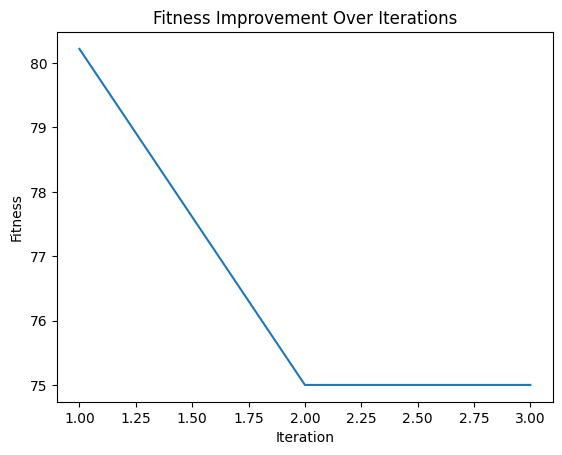

In [4]:

class Particle:
    def __init__(self, initial_position):
        self.position = initial_position.copy()
        self.velocity = [random.uniform(-1, 1) for _ in range(len(initial_position))]
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')

def initialize_particles(num_particles, initial_timings):
    particles = [Particle(initial_timings) for _ in range(num_particles)]
    return particles

def modify_network_xml(durations, network_file, modified_network_file):
    shutil.copy(network_file, modified_network_file)
    tree = ET.parse(modified_network_file)
    root = tree.getroot()

    for tl in root.findall('tlLogic'):
        phases = tl.findall('phase')
        for i in range(0, len(phases), 4):
            phases[i].set('duration', str(int(durations[0])))
            phases[i + 1].set('duration', str(int(durations[1])))
            phases[i + 2].set('duration', str(int(durations[0])))
            phases[i + 3].set('duration', str(int(durations[1])))

    tree.write(modified_network_file)

def run_sumo_simulation(config_file, modified_network_file, tripinfo_file):
    
    traci.start(['sumo-gui', '-c', config_file, '--net-file', modified_network_file, '--tripinfo-output', tripinfo_file, '--start', '--quit-on-end', '--scale', '1'])
    
    vehicle_id = "10"
    total_travel_time = 0

    # Start simulation explicitly
    traci.simulationStep()

    # Run the simulation for 1000 steps
    step = 0
    while step < 1000:
        # Run the simulation
        traci.simulationStep()
        step += 1

    traci.close()
    
    # Get the total travel time of the vehicle from the tripinfo file
    tree = ET.parse(tripinfo_file)
    root = tree.getroot()
    for trip in root.findall('tripinfo'):
        if trip.get('id') == vehicle_id:
            total_travel_time = float(trip.get('duration'))
    
    return total_travel_time


def evaluate_fitness(durations, config_file, network_file, tripinfo_file, modified_network_file):
    modify_network_xml(durations, network_file, modified_network_file)
    total_travel_time = run_sumo_simulation(config_file, modified_network_file, tripinfo_file)
    fitness_value = total_travel_time
    return fitness_value

def pso(num_particles, max_iterations, min_duration, max_duration, num_phases, initial_timings, config_file, network_file, tripinfo_file, modified_network_file):
    particles = []
    global_best_position = initial_timings.copy()
    global_best_fitness = float('inf')
    fitness_values = []

    # Initialize the particles
    for _ in range(num_particles):
        position = [random.randint(min_duration, max_duration) for _ in range(num_phases)]
        velocity = [random.uniform(-1, 1) for _ in range(num_phases)]
        particle = {
            'position': position,
            'velocity': velocity,
            'best_position': position.copy(),
            'best_fitness': float('inf')
        }
        particles.append(particle)

    for iteration in range(max_iterations):
        fitness_vals = []
        for particle in particles:
            # Evaluate the fitness of the particle
            fitness = evaluate_fitness(particle['position'], config_file, network_file, tripinfo_file, modified_network_file)

            # Update the best position and fitness of the particle
            if fitness < particle['best_fitness']:
                particle['best_position'] = particle['position'].copy()
                particle['best_fitness'] = fitness

            # Update the best position and fitness of the swarm
            if fitness < global_best_fitness:
                global_best_position = particle['position'].copy()
                global_best_fitness = fitness
        
            fitness_vals.append(global_best_fitness)
        
        fitness_values.append(sum(fitness_vals) / len(fitness_vals))

        w = 0.5 # Inertia weight
        c1 = 1.5 # Cognitive component
        s1 = 1.5 # Social component

        for particle in particles:
            for i in range(num_phases):
                # update the velocity and position of the particle
                r1 = random.random()
                r2 = random.random()
                cognitive_component = c1 * r1 * (particle['best_position'][i] - particle['position'][i])
                social_component = s1 * r2 * (global_best_position[i] - particle['position'][i])
                
                # Update the velocity and position of the particle
                particle['velocity'][i] = w * particle['velocity'][i] + cognitive_component + social_component
                particle['velocity'][i] = max(min(-max_duration, particle['velocity'][i]), max_duration)
                particle['position'][i] += particle['velocity'][i]
                particle['position'][i] = max(min_duration, min(max_duration, particle['position'][i]))

        # Modify the network file with the best traffic light timings
        modify_network_xml(global_best_position, network_file, modified_network_file)
        print(f"Iteration {iteration}: Best traffic light timings: {global_best_position[0:2]}, Best fitness: {global_best_fitness}")

    return global_best_position, global_best_fitness, fitness_values

# PSO Parameters
num_particles = 50 # Number of particles
max_iterations = 3 # Number of iterations
min_duration = 5  # Minimum phase duration
max_duration = 30  # Maximum phase duration
num_phases = 2  # Number of traffic light phases
initial_timings = [10, 4, 10, 4]  # Initial traffic light timings

# Paths to SUMO files
sumo_config_file = '../sumo_files/config.sumo.cfg'
network_file = '../sumo_files/network.net.xml'
tripinfo_file = '../sumo_files/tripinfo.xml'
modified_network_file = '../sumo_files/network_modified.net.xml'

# Create the modified network file if it doesn't exist
if not os.path.exists(modified_network_file):
    os.makedirs(os.path.dirname(modified_network_file), exist_ok=True)
    shutil.copy(network_file, modified_network_file)

# Run the PSO optimization
best_timings, best_fitness, fitness_values = pso(num_particles, max_iterations, min_duration, max_duration, num_phases, initial_timings, sumo_config_file, network_file, tripinfo_file, modified_network_file)

# Output the final best traffic light timings and fitness
print("Final best traffic light timings:", best_timings)
print("Final best fitness (Minimum travel time):", best_fitness)

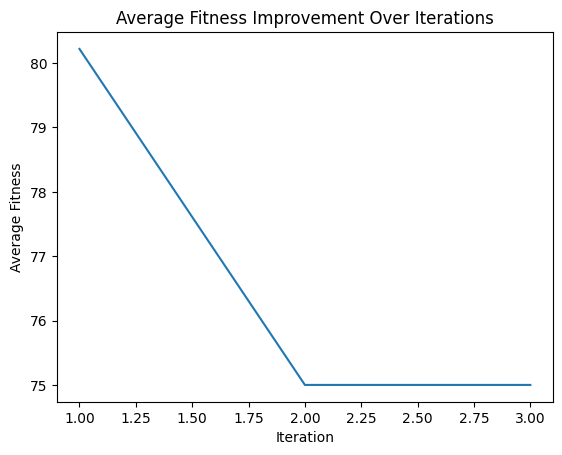

In [6]:
# compute average fitness in the fitness values

plt.plot(range(1, len(fitness_values) + 1), fitness_values)
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.title('Average Fitness Improvement Over Iterations')
plt.show()